In [5]:
%cd /Volumes/Samsung_T5/ProtPredict/scripts

/Volumes/Samsung_T5/ProtPredict/scripts


## Load dependencies

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, KFold
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from other import create_features, Bayes_CV, return_protein_dataset, extract_shap_return_absmeans, extract_xgb_feature_values

## Define initial parameters
Define initial parameters, such as number of workers, cross-validation setup and which protein to use for model optimization.

In [ ]:
n_parallel = 60 #If parallel, define n workers

#define the K in the cross-validation strategies
cvcount_inner = 5 #K-fold for optimization
cvcount_outer = 5 #K-fold for evaluation

opt_protein = 'A5Z2X5' #protein to optimize the models on

## Load the data-sets

Load the needed data-sets.
Data-set from Messner et al. (https://www.biorxiv.org/content/10.1101/2022.05.17.492318v1 (Data-sets need to be downloaded separately).

The "function create_features" will merge the input data-set (from Messner et al.) with the relational features generated in Aleph.

In [ ]:
#load the proteomics dataset from Messner et al. (2022)
proteomic_dataset = pd.read_csv('../data/proteomics_messner.csv')
proteomic_dataset = proteomic_dataset.groupby('Unnamed: 0').mean() #Average potential duplicate rows

#paths to relational features
path_features = '../intermediateData/generated_features/proteomics_features.txt' #ordered features
path_labels = '../intermediateData/generated_features/proteomics.txt' #ordered positve examples

#reformat the relational features and merge them with the proteomics dataset
dataset = create_features(path_features, path_labels, proteomics_dataset)

## Model optimization

Optimize/tune hyperparameters for XGBoost using bayesian optimization. In the study, the model is being tuned on the first example in the data-set (Uniprot: A5Z2X5, Common: MIN8, ORF: YPR010C-A)

In [ ]:
#Define parameter space to search
params={'gamma': (0.0,1.0),
        'max_depth': (2, 12),
        'subsample': (0.4, 1.0),
        'learning_rate':(0.005,0.3,'log-uniform'),
        'n_estimators':(10,1000),
        'colsample_bytree':(0.4, 1.0),
        'reg_lambda':(0.0,1.0),
        'reg_alpha':(0.0,0.5)}

#Function to define X and Y
X, y, nancount = return_protein_dataset(dataset, opt_protein)

#define the bayesian optimization process
best_params = Bayes_CV(params, X, y, cvcount_inner, n_parallel, 0)

## Train the models

Train the models for all of the separate proteins using XGBoost and evaluate with 5-fold CV and save them for later use. 

In [ ]:
#predefine scoring frame
scores = pd.DataFrame(columns = ['Protein','MissingY','R-squared','RMSE'])

for Protein in dataset.columns[:2292]:

    X, y, nancount = return_protein_dataset(dataset, Protein)

    #define regressor and evaluate model
    regressor = XGBRegressor(random_state = 0, n_jobs = n_parallel, **best_params)
    outer_cv = KFold(n_splits=cvcount_outer, shuffle=True, random_state=0)
    score_all = cross_validate(regressor, X, np.ravel(y), cv=outer_cv, scoring = ('r2', 'neg_root_mean_squared_error'))
    score = score_all['test_r2']
    rmse = score_all['test_neg_root_mean_squared_error']

    #save scores
    temp_df = pd.DataFrame([[Protein, nancount,score[0],rmse[0]], [Protein, nancount,score[1],rmse[1]], [Protein, nancount,score[2],rmse[2]], 
            [Protein, nancount,score[3],rmse[3]], [Protein, nancount,score[4],rmse[4]]], columns=['Protein', 'MissingY', 'R-squared', 'RMSE'])
    scores = scores.append(temp_df)
    scores.to_csv('../results/evaluation/ILP/protfromILP_results.csv')
    

## Visualize performance metrics

Visualize average cross-validation performance (in R2) across the space of available proteins in the data-set.

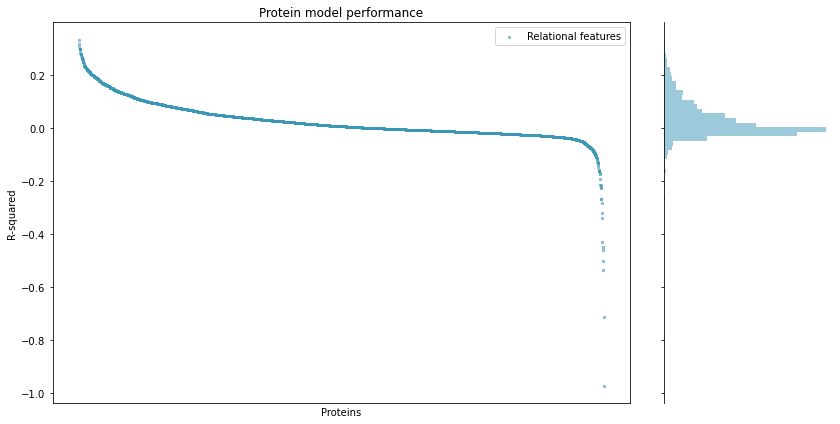

In [16]:
#data = pd.read_csv('../results/evaluation/ILP/protfromILP_results.csv', index_col = 0)
data = pd.read_csv('../results/evaluation/ILP/ILP_20230309.csv', index_col = 0)
data_mean = data.groupby(by='Protein').mean() #group and take the average of folds
data_mean = data_mean.sort_values(by = 'R-squared', ascending = False) #sort by average

fig = plt.figure(figsize = (14,7))
gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[0:4,0:3])
ax_marg_y = fig.add_subplot(gs[0:4,3])
ax_joint.scatter(x = data_mean.index,y = data_mean['R-squared'], alpha = 0.5, marker = 's', s = 7, label='ILP', color = '#3B97B6')

ax_marg_y.hist(data_mean['R-squared'],orientation="horizontal", bins = 75, alpha = 0.5, density = True, color = '#3B97B6')

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Proteins')
ax_joint.set_ylabel('R-squared')

ax_marg_y.spines['top'].set_visible(False)
ax_marg_y.spines['right'].set_visible(False)
ax_marg_y.spines['bottom'].set_visible(False)

ax_joint.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax_marg_y.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax_joint.legend(['Relational features'])
ax_joint.set_title('Protein model performance')
plt.show()

## Extract SHAP-values

Extract SHAP-values to be used for later analysis.

In [ ]:
shapmeans_proteins = pd.DataFrame(index = dataset.columns[2292:]) #predefine df for feature shap-values
for Protein in dataset.columns[:2292]:
    
    X, y, nancount = return_protein_dataset(dataset, Protein)
    
    #train regressor
    regressor = XGBRegressor(random_state = 0, n_jobs = n_parallel, **best_params)
    regressor.fit(X,y)
    
    #extract shap-values (in the form of abs(average)) for all proteins in the dataset
    shapmeans_proteins = extract_shap_return_absmeans(regressor, X, Protein, shapmeans_proteins)
    shapmeans_proteins.to_csv('../intermediateData/feature_values/ILP/Proteins_ILP_SHAP_means.tsv', sep = '\t')
    
    #extract all XGB-feature values (gain, total gain, ...) and save protein result each separately
    xgb_feature_values = extract_xgb_feature_values(regressor)
    xgb_feature_values.to_csv('../intermediateData/feature_values/ILP/'+Protein+'_ILP_XGB.tsv', sep = '\t')

## Calculate and visualize feature importance

Filter out proteins with an R-squared below 0.0, and use the remaining proteins to visualize global feature importances.

SHAP-values across the entire space of proteins was calculated by normalizing each column (protein model) by dividing with the sum of the column. The normalized feature-values were then averaged across the proteins.

XGB-gain values were averaged across the space of predictable proteins.

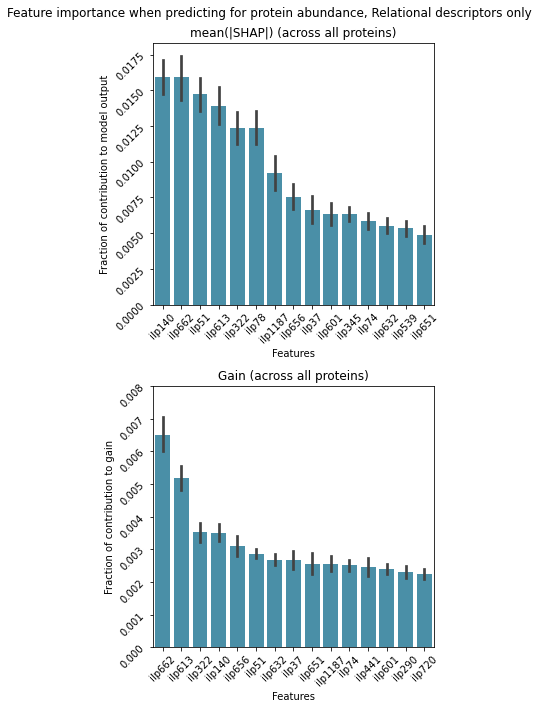

In [15]:
#load evaluation data
data = pd.read_csv('../results/evaluation/ILP/ILP_20230309.csv', index_col = 0)
data_mean = data.groupby(by='Protein').mean() #average the folds

#Figure 3 - overall feature dependencies for predictions given in Figure 2!
#Only include models with an r2 of above 0!
list_to_include = list(data_mean[data_mean['R-squared'] > 0].index)
feature_shap = pd.read_csv('../results/feature_values/ILP/SHAP/ILP_SHAP_20230310.tsv', sep = '\t', index_col = 0)
feature_shap = feature_shap[feature_shap.columns.intersection(list_to_include)]

#Normalize columns by dividing with total sum and then average
for col in feature_shap.columns:
    feature_shap[col] = feature_shap[col]/feature_shap[col].sum(axis = 0)
fmeans = feature_shap.mean(axis = 1)

#do the same with XGB-values?
features_XGB = pd.DataFrame(index = feature_shap.index)
path = '../results/feature_values/ILP/XGB/'

for files in os.listdir(path):
    
    if files.split('_')[0] in list_to_include:
        
        if '20230310' in files:
            xgb_features = pd.DataFrame(pd.read_csv(path+files, sep = '\t', index_col = 0)['gain'])
            xgb_features.columns = [files.split('_')[0]]
         
            features_XGB = pd.merge(features_XGB, xgb_features, left_index = True, right_index = True, how = 'left')
            features_XGB = features_XGB.fillna(0)
            features_XGB[files.split('_')[0]] = features_XGB[files.split('_')[0]]/features_XGB[files.split('_')[0]].sum(axis = 0) 
        
xgbmeans = features_XGB.mean(axis = 1)

#pick top features by mean
nr_to_include = 15

fig, axes = plt.subplots(2, 1, figsize=(5, 10))
fig.suptitle('Feature importance when predicting for protein abundance, Relational descriptors only')

#shap
sns.barplot(ax = axes[0], data = feature_shap.transpose()[fmeans.nlargest(nr_to_include).index], color = '#3B97B6')#619CFF'
axes[0].set_title('mean(|SHAP|) (across all proteins)')
axes[0].tick_params(labelrotation=45)
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Fraction of contribution to model output')

#xgb
sns.barplot(ax = axes[1], data = features_XGB.transpose()[xgbmeans.nlargest(nr_to_include).index], color = '#3B97B6')
axes[1].set_title('Gain (across all proteins)')
axes[1].tick_params(labelrotation=45)
axes[1].set_ylim([0.00,0.008])
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Fraction of contribution to gain')
plt.tight_layout()